In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import torch.nn.functional as F  
import matplotlib.pyplot as plt

In [2]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)
print(len(cifar10_test))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
10000


In [3]:
import os
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)


using device: cuda


In [5]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [45]:
def check_accuracy(loader, model,Accuracy_list):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    flag = 2
    with torch.no_grad():
        for x, y in loader:
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
        acc = float(num_correct) / num_samples 
#         if acc>=best_acc:
#             flag = 1
#         else:
#             flag = 0     
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        Accuracy_list.append(100*acc)
        #return flag

In [46]:
def test_accuracy(loader, model):

    print('Checking accuracy on test set ====> ')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples 
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        #Accuracy_list.append(100*acc)
        return 100 * acc 

In [47]:
def train_process(model, optimizer, epochs, rounds,scale,Loss_list,Accuracy_list):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    best_model = None
    best_acc = 0
    print("====> rounds: "+ str(rounds))
    #print("====> lr: " + str)
    for e in range(epochs):
        print("Epoch====>%d" % e)
        for t, (x, y) in enumerate(loader_train):
            #print(x.shape)
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y) * scale + 0.2

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                Loss_list.append(loss.item())
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(loader_val, model,Accuracy_list)
                acc = test_accuracy(loader_test,model)
                if acc> best_acc:
                    best_model = model
                    best_acc = acc
                
            
    
    return best_model,best_acc
                

In [9]:
def weights_init(m):
    classname=m.__class__.__name__
    if classname.find('conv') != -1:
        xavier(m.weight.data)
        xavier(m.bias.data)

In [10]:
import torch.nn.functional as F  
## model A
learning_rate = 1e-2

model = None
optimizer = None

class NetA(nn.Module):
    def __init__(self):
        super(NetA, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 5,stride=1,padding=2)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 192, 5,stride=1,padding=2)
        self.conv3 = nn.Conv2d(192,192,3,stride=1,padding=1)
        self.conv4 = nn.Conv2d(192,192,1)
        self.conv5 = nn.Conv2d(192,10,1)
        #self.fc1 = nn.Linear(49,10)
        self.grouppool = nn.AvgPool2d(6,6)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        
        #print(x.shape)
        x = self.grouppool(x)
        x = x.view(x.shape[0],-1)
        #x = F.softmax(x)
#         x = self.fc1(x)
        return x



In [42]:
Loss_list = []
Accuracy_list = []
learning_rate = 0.00976
modelA = NetA()
decay = 0.7
best_acc = 0
best_model = None
for i in range(20):
    if i!=0:
        modelA = best_model
    if i%4==0 and i!=0:
        learning_rate = learning_rate*decay
        
    optimizer = optim.SGD(modelA.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
    modelA,acc = train_process(modelA,optimizer,epochs=1,rounds=i,scale=3.0,Loss_list=Loss_list,Accuracy_list=Accuracy_list)
    if acc > best_acc:
        best_model = modelA
        best_acc = acc
        print("gotcha!")
        print("best_acc: "+str(best_acc))
    else:
        print("no better")
torch.save(best_model,'./v2_models/modelA.pkl')

====> rounds: 0
Epoch====>0
Iteration 0, loss = 7.1326
Checking accuracy on validation set
Got 108 / 1000 correct (10.80)
Checking accuracy on test set ====> 
Got 1212 / 10000 correct (12.12)
Iteration 100, loss = 6.3195
Checking accuracy on validation set
Got 301 / 1000 correct (30.10)
Checking accuracy on test set ====> 
Got 2832 / 10000 correct (28.32)
Iteration 200, loss = 6.1143
Checking accuracy on validation set
Got 365 / 1000 correct (36.50)
Checking accuracy on test set ====> 
Got 3581 / 10000 correct (35.81)
Iteration 300, loss = 4.9472
Checking accuracy on validation set
Got 410 / 1000 correct (41.00)
Checking accuracy on test set ====> 
Got 3962 / 10000 correct (39.62)
Iteration 400, loss = 4.7167
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)
Checking accuracy on test set ====> 
Got 4519 / 10000 correct (45.19)
Iteration 500, loss = 3.7060
Checking accuracy on validation set
Got 522 / 1000 correct (52.20)
Checking accuracy on test set ====> 
Got 5206 / 

Got 8203 / 10000 correct (82.03)
gotcha!
best_acc: 82.03
====> rounds: 6
Epoch====>0
Iteration 0, loss = 1.0417
Checking accuracy on validation set
Got 815 / 1000 correct (81.50)
Checking accuracy on test set ====> 
Got 8131 / 10000 correct (81.31)
Iteration 100, loss = 1.1812
Checking accuracy on validation set
Got 835 / 1000 correct (83.50)
Checking accuracy on test set ====> 
Got 8146 / 10000 correct (81.46)
Iteration 200, loss = 1.2816
Checking accuracy on validation set
Got 808 / 1000 correct (80.80)
Checking accuracy on test set ====> 
Got 8050 / 10000 correct (80.50)
Iteration 300, loss = 1.6278
Checking accuracy on validation set
Got 833 / 1000 correct (83.30)
Checking accuracy on test set ====> 
Got 8115 / 10000 correct (81.15)
Iteration 400, loss = 1.5585
Checking accuracy on validation set
Got 823 / 1000 correct (82.30)
Checking accuracy on test set ====> 
Got 8198 / 10000 correct (81.98)
Iteration 500, loss = 1.7131
Checking accuracy on validation set
Got 807 / 1000 correct

Got 8273 / 10000 correct (82.73)
no better
====> rounds: 12
Epoch====>0
Iteration 0, loss = 0.4599
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)
Checking accuracy on test set ====> 
Got 8339 / 10000 correct (83.39)
Iteration 100, loss = 0.4423
Checking accuracy on validation set
Got 839 / 1000 correct (83.90)
Checking accuracy on test set ====> 
Got 8461 / 10000 correct (84.61)
Iteration 200, loss = 0.6388
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)
Checking accuracy on test set ====> 
Got 8452 / 10000 correct (84.52)
Iteration 300, loss = 0.4345
Checking accuracy on validation set
Got 848 / 1000 correct (84.80)
Checking accuracy on test set ====> 
Got 8470 / 10000 correct (84.70)
Iteration 400, loss = 0.4257
Checking accuracy on validation set
Got 837 / 1000 correct (83.70)
Checking accuracy on test set ====> 
Got 8432 / 10000 correct (84.32)
Iteration 500, loss = 0.3921
Checking accuracy on validation set
Got 848 / 1000 correct (84.80)
Chec

Got 8546 / 10000 correct (85.46)
gotcha!
best_acc: 85.59
====> rounds: 18
Epoch====>0
Iteration 0, loss = 0.2135
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)
Checking accuracy on test set ====> 
Got 8526 / 10000 correct (85.26)
Iteration 100, loss = 0.2032
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)
Checking accuracy on test set ====> 
Got 8541 / 10000 correct (85.41)
Iteration 200, loss = 0.2099
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)
Checking accuracy on test set ====> 
Got 8534 / 10000 correct (85.34)
Iteration 300, loss = 0.2073
Checking accuracy on validation set
Got 856 / 1000 correct (85.60)
Checking accuracy on test set ====> 
Got 8528 / 10000 correct (85.28)
Iteration 400, loss = 0.2094
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)
Checking accuracy on test set ====> 
Got 8536 / 10000 correct (85.36)
Iteration 500, loss = 0.2137
Checking accuracy on validation set
Got 858 / 1000 correc

/root/Anaconda/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NetA. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


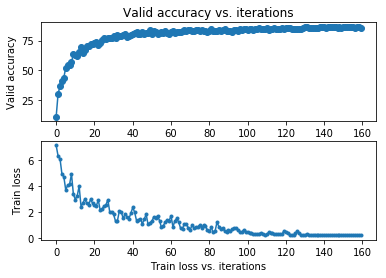

In [43]:
x1 = range(0, len(Accuracy_list)) # 8*5*5
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Valid accuracy vs. iterations')
plt.ylabel('Valid accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. iterations')
plt.ylabel('Train loss')
plt.show()
#plt.savefig("accuracy_loss.jpg")


In [44]:
test_accuracy(loader_test, best_model)

Checking accuracy on test set ====> 
Got 8537 / 10000 correct (85.37)


85.37

In [48]:
import torch.nn.functional as F  
## model B


model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################

class NetB(nn.Module):
    def __init__(self):
        super(NetB, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 5,stride=1,padding=2)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 96, 1)
        self.conv3 = nn.Conv2d(96,192,5,stride=1,padding=2)
        self.conv4 = nn.Conv2d(192,192,1)
        self.conv5 = nn.Conv2d(192,192,3,stride=1,padding=1)
        self.conv6 = nn.Conv2d(192,192,1)
        self.conv7 = nn.Conv2d(192,10,1)
        self.grouppool = nn.AvgPool2d(6,6)        
        #self.fc1 = nn.Linear(40,10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        #x = F.softmax(x)
        x = self.grouppool(x)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        #x = self.fc1(x)
        return x



In [50]:
Loss_list = []
Accuracy_list = []
learning_rate = 0.01
modelB = NetB()
modelB.apply(weights_init)
best_acc = 0
best_model = None

#modelA = best_model
decay = 0.7


for i in range(20):
    if i!=0:
        modelB = best_model
    if i%4==0 and i!=0:
        learning_rate = learning_rate*decay
        
    optimizer = optim.SGD(modelB.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
    modelB,acc = train_process(modelB,optimizer,epochs=1,rounds=i,scale=3.0,Loss_list=Loss_list,Accuracy_list=Accuracy_list)
    if acc > best_acc:
        best_model = modelB
        best_acc = acc
        print("gotcha!")
        print("best_acc: "+str(best_acc))
    else:
        print("no better")
torch.save(best_model,'./v2_models/modelB.pkl')

====> rounds: 0
Epoch====>0
Iteration 0, loss = 7.1104
Checking accuracy on validation set
Got 133 / 1000 correct (13.30)
Checking accuracy on test set ====> 
Got 1210 / 10000 correct (12.10)
Iteration 100, loss = 7.1270
Checking accuracy on validation set
Got 179 / 1000 correct (17.90)
Checking accuracy on test set ====> 
Got 1908 / 10000 correct (19.08)
Iteration 200, loss = 6.3817
Checking accuracy on validation set
Got 235 / 1000 correct (23.50)
Checking accuracy on test set ====> 
Got 2362 / 10000 correct (23.62)
Iteration 300, loss = 5.7970
Checking accuracy on validation set
Got 271 / 1000 correct (27.10)
Checking accuracy on test set ====> 
Got 2822 / 10000 correct (28.22)
Iteration 400, loss = 4.8637
Checking accuracy on validation set
Got 401 / 1000 correct (40.10)
Checking accuracy on test set ====> 
Got 3582 / 10000 correct (35.82)
Iteration 500, loss = 5.1571
Checking accuracy on validation set
Got 361 / 1000 correct (36.10)
Checking accuracy on test set ====> 
Got 3873 / 

Got 8026 / 10000 correct (80.26)
gotcha!
best_acc: 81.9
====> rounds: 6
Epoch====>0
Iteration 0, loss = 1.8175
Checking accuracy on validation set
Got 807 / 1000 correct (80.70)
Checking accuracy on test set ====> 
Got 8066 / 10000 correct (80.66)
Iteration 100, loss = 1.5698
Checking accuracy on validation set
Got 813 / 1000 correct (81.30)
Checking accuracy on test set ====> 
Got 8151 / 10000 correct (81.51)
Iteration 200, loss = 0.6740
Checking accuracy on validation set
Got 824 / 1000 correct (82.40)
Checking accuracy on test set ====> 
Got 8172 / 10000 correct (81.72)
Iteration 300, loss = 1.4075
Checking accuracy on validation set
Got 798 / 1000 correct (79.80)
Checking accuracy on test set ====> 
Got 7946 / 10000 correct (79.46)
Iteration 400, loss = 1.0137
Checking accuracy on validation set
Got 779 / 1000 correct (77.90)
Checking accuracy on test set ====> 
Got 7988 / 10000 correct (79.88)
Iteration 500, loss = 2.1349
Checking accuracy on validation set
Got 825 / 1000 correct 

Got 841 / 1000 correct (84.10)
Checking accuracy on test set ====> 
Got 8347 / 10000 correct (83.47)
no better
====> rounds: 12
Epoch====>0
Iteration 0, loss = 0.5040
Checking accuracy on validation set
Got 821 / 1000 correct (82.10)
Checking accuracy on test set ====> 
Got 8327 / 10000 correct (83.27)
Iteration 100, loss = 0.5929
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)
Checking accuracy on test set ====> 
Got 8418 / 10000 correct (84.18)
Iteration 200, loss = 0.3573
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)
Checking accuracy on test set ====> 
Got 8450 / 10000 correct (84.50)
Iteration 300, loss = 0.5638
Checking accuracy on validation set
Got 854 / 1000 correct (85.40)
Checking accuracy on test set ====> 
Got 8474 / 10000 correct (84.74)
Iteration 400, loss = 0.3868
Checking accuracy on validation set
Got 852 / 1000 correct (85.20)
Checking accuracy on test set ====> 
Got 8425 / 10000 correct (84.25)
Iteration 500, loss = 0.5171
Che

Got 860 / 1000 correct (86.00)
Checking accuracy on test set ====> 
Got 8546 / 10000 correct (85.46)
gotcha!
best_acc: 85.64
====> rounds: 18
Epoch====>0
Iteration 0, loss = 0.2004
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)
Checking accuracy on test set ====> 
Got 8555 / 10000 correct (85.55)
Iteration 100, loss = 0.2035
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)
Checking accuracy on test set ====> 
Got 8561 / 10000 correct (85.61)
Iteration 200, loss = 0.2397
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)
Checking accuracy on test set ====> 
Got 8579 / 10000 correct (85.79)
Iteration 300, loss = 0.2008
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)
Checking accuracy on test set ====> 
Got 8571 / 10000 correct (85.71)
Iteration 400, loss = 0.2329
Checking accuracy on validation set
Got 863 / 1000 correct (86.30)
Checking accuracy on test set ====> 
Got 8595 / 10000 correct (85.95)
Iteration 500, los

/root/Anaconda/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NetB. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


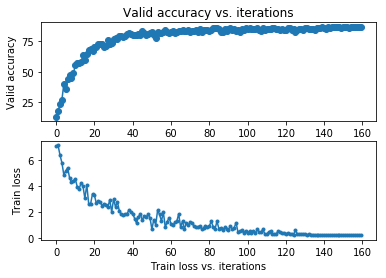

In [51]:
x1 = range(0, len(Accuracy_list)) # 8*5*5
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Valid accuracy vs. iterations')
plt.ylabel('Valid accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. iterations')
plt.ylabel('Train loss')
plt.show()

In [52]:
test_accuracy(loader_test, best_model)

Checking accuracy on test set ====> 
Got 8590 / 10000 correct (85.90)


85.89999999999999

In [68]:
import torch.nn.functional as F  
## model C
class NetC(nn.Module):
    def __init__(self):
        super(NetC, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 96, 3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(96,192,3,stride=1,padding=1)
        self.conv4 = nn.Conv2d(192,192,3,stride=1,padding=1)
        self.conv5 = nn.Conv2d(192,192,3,stride=1,padding=1)
        self.conv6 = nn.Conv2d(192,192,1)
        self.conv7 = nn.Conv2d(192,10,1)
        self.grouppool = nn.AvgPool2d(6,6)
        #self.fc1 = nn.Linear(40,10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        #x = F.softmax(x)
        x = self.grouppool(x)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        #x = self.fc1(x)
        return x


In [71]:
Loss_list = []
Accuracy_list = []
learning_rate = 0.01
modelC = NetC()
modelC.apply(weights_init)
best_acc = 0
best_model = None

#modelA = best_model
decay = 0.6


for i in range(30):
    if i!=0:
        modelC = best_model
    if i%4==0 and i!=0:
        learning_rate = learning_rate*decay
        
    optimizer = optim.SGD(modelC.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
    modelB,acc = train_process(modelC,optimizer,epochs=1,rounds=i,scale=3.0,Loss_list=Loss_list,Accuracy_list=Accuracy_list)
    if acc > best_acc:
        best_model = modelC
        best_acc = acc
        print("gotcha!")
        print("best_acc: "+str(best_acc))
    else:
        print("no better")
torch.save(best_model,'./v2_models/modelC.pkl')

====> rounds: 0
Epoch====>0
Iteration 0, loss = 7.1138
Checking accuracy on validation set
Got 201 / 2000 correct (10.05)
Checking accuracy on test set ====> 
Got 1000 / 10000 correct (10.00)
Iteration 100, loss = 7.0499
Checking accuracy on validation set
Got 364 / 2000 correct (18.20)
Checking accuracy on test set ====> 
Got 1937 / 10000 correct (19.37)
Iteration 200, loss = 6.5858
Checking accuracy on validation set
Got 433 / 2000 correct (21.65)
Checking accuracy on test set ====> 
Got 2058 / 10000 correct (20.58)
Iteration 300, loss = 5.9675
Checking accuracy on validation set
Got 535 / 2000 correct (26.75)
Checking accuracy on test set ====> 
Got 2585 / 10000 correct (25.85)
Iteration 400, loss = 6.3615
Checking accuracy on validation set
Got 530 / 2000 correct (26.50)
Checking accuracy on test set ====> 
Got 2782 / 10000 correct (27.82)
Iteration 500, loss = 6.5408
Checking accuracy on validation set
Got 491 / 2000 correct (24.55)
Checking accuracy on test set ====> 
Got 2350 / 

Got 1659 / 2000 correct (82.95)
Checking accuracy on test set ====> 
Got 8115 / 10000 correct (81.15)
gotcha!
best_acc: 81.88
====> rounds: 6
Epoch====>0
Iteration 0, loss = 1.5707
Checking accuracy on validation set
Got 1666 / 2000 correct (83.30)
Checking accuracy on test set ====> 
Got 8205 / 10000 correct (82.05)
Iteration 100, loss = 0.8069
Checking accuracy on validation set
Got 1671 / 2000 correct (83.55)
Checking accuracy on test set ====> 
Got 8211 / 10000 correct (82.11)
Iteration 200, loss = 0.8802
Checking accuracy on validation set
Got 1650 / 2000 correct (82.50)
Checking accuracy on test set ====> 
Got 8220 / 10000 correct (82.20)
Iteration 300, loss = 0.8540
Checking accuracy on validation set
Got 1660 / 2000 correct (83.00)
Checking accuracy on test set ====> 
Got 8196 / 10000 correct (81.96)
Iteration 400, loss = 1.2630
Checking accuracy on validation set
Got 1639 / 2000 correct (81.95)
Checking accuracy on test set ====> 
Got 8194 / 10000 correct (81.94)
Iteration 500

Got 8368 / 10000 correct (83.68)
Iteration 700, loss = 0.4829
Checking accuracy on validation set
Got 1697 / 2000 correct (84.85)
Checking accuracy on test set ====> 
Got 8435 / 10000 correct (84.35)
no better
====> rounds: 12
Epoch====>0
Iteration 0, loss = 0.3372
Checking accuracy on validation set
Got 1705 / 2000 correct (85.25)
Checking accuracy on test set ====> 
Got 8386 / 10000 correct (83.86)
Iteration 100, loss = 0.2055
Checking accuracy on validation set
Got 1712 / 2000 correct (85.60)
Checking accuracy on test set ====> 
Got 8478 / 10000 correct (84.78)
Iteration 200, loss = 0.2335
Checking accuracy on validation set
Got 1708 / 2000 correct (85.40)
Checking accuracy on test set ====> 
Got 8516 / 10000 correct (85.16)
Iteration 300, loss = 0.2816
Checking accuracy on validation set
Got 1710 / 2000 correct (85.50)
Checking accuracy on test set ====> 
Got 8540 / 10000 correct (85.40)
Iteration 400, loss = 0.3927
Checking accuracy on validation set
Got 1706 / 2000 correct (85.30

Got 1727 / 2000 correct (86.35)
Checking accuracy on test set ====> 
Got 8551 / 10000 correct (85.51)
Iteration 700, loss = 0.2006
Checking accuracy on validation set
Got 1724 / 2000 correct (86.20)
Checking accuracy on test set ====> 
Got 8548 / 10000 correct (85.48)
no better
====> rounds: 18
Epoch====>0
Iteration 0, loss = 0.2007
Checking accuracy on validation set
Got 1727 / 2000 correct (86.35)
Checking accuracy on test set ====> 
Got 8549 / 10000 correct (85.49)
Iteration 100, loss = 0.2003
Checking accuracy on validation set
Got 1728 / 2000 correct (86.40)
Checking accuracy on test set ====> 
Got 8547 / 10000 correct (85.47)
Iteration 200, loss = 0.2051
Checking accuracy on validation set
Got 1723 / 2000 correct (86.15)
Checking accuracy on test set ====> 
Got 8557 / 10000 correct (85.57)
Iteration 300, loss = 0.2002
Checking accuracy on validation set
Got 1726 / 2000 correct (86.30)
Checking accuracy on test set ====> 
Got 8549 / 10000 correct (85.49)
Iteration 400, loss = 0.20

Got 1724 / 2000 correct (86.20)
Checking accuracy on test set ====> 
Got 8562 / 10000 correct (85.62)
Iteration 700, loss = 0.2001
Checking accuracy on validation set
Got 1725 / 2000 correct (86.25)
Checking accuracy on test set ====> 
Got 8559 / 10000 correct (85.59)
no better
====> rounds: 24
Epoch====>0
Iteration 0, loss = 0.2003
Checking accuracy on validation set
Got 1724 / 2000 correct (86.20)
Checking accuracy on test set ====> 
Got 8558 / 10000 correct (85.58)
Iteration 100, loss = 0.2017
Checking accuracy on validation set
Got 1723 / 2000 correct (86.15)
Checking accuracy on test set ====> 
Got 8554 / 10000 correct (85.54)
Iteration 200, loss = 0.2005
Checking accuracy on validation set
Got 1725 / 2000 correct (86.25)
Checking accuracy on test set ====> 
Got 8556 / 10000 correct (85.56)
Iteration 300, loss = 0.2006
Checking accuracy on validation set
Got 1725 / 2000 correct (86.25)
Checking accuracy on test set ====> 
Got 8553 / 10000 correct (85.53)
Iteration 400, loss = 0.20

Got 1722 / 2000 correct (86.10)
Checking accuracy on test set ====> 
Got 8562 / 10000 correct (85.62)
Iteration 700, loss = 0.2004
Checking accuracy on validation set
Got 1723 / 2000 correct (86.15)
Checking accuracy on test set ====> 
Got 8561 / 10000 correct (85.61)
no better


/root/Anaconda/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NetC. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


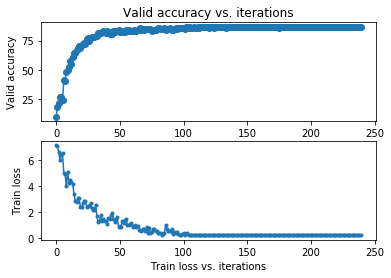

In [73]:
x1 = range(0, len(Accuracy_list)) # 8*10*6
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Valid accuracy vs. iterations')
plt.ylabel('Valid accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. iterations')
plt.ylabel('Train loss')
plt.show()

In [53]:
import torch.nn.functional as F  
## model CA


model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################

class NetCA(nn.Module):
    def __init__(self):
        super(NetCA, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 96, 3,stride=2,padding=1)
        self.conv3 = nn.Conv2d(96,192,3,stride=1,padding=1)
        self.conv4 = nn.Conv2d(192,192,3,stride=2,padding=1)
        # 
        self.conv5 = nn.Conv2d(192,192,3,stride=1,padding=1)
        self.conv6 = nn.Conv2d(192,192,1)
        self.conv7 = nn.Conv2d(192,10,1)
        self.grouppool = nn.AvgPool2d(6,6)
        #self.fc1 = nn.Linear(40,10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))    
        x = self.grouppool(x)
        x = x.view(x.shape[0],-1)
        #x = F.softmax(x)
        #print(x.shape)
        #x = self.fc1(x)
        return x



In [54]:
Loss_list = []
Accuracy_list = []
learning_rate = 0.007
modelCA = NetCA()
modelCA.apply(weights_init)
best_acc = 0
best_model = None

#modelA = best_model
decay = 0.8


for i in range(25):
    if i!=0:
        modelCA = best_model
    if i%4==0 and i!=0:
        learning_rate = learning_rate*decay
        
    optimizer = optim.SGD(modelCA.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
    modelB,acc = train_process(modelCA,optimizer,epochs=1,rounds=i,scale=2.0,Loss_list=Loss_list,Accuracy_list=Accuracy_list)
    if acc > best_acc:
        best_model = modelCA
        best_acc = acc
        print("gotcha!")
        print("best_acc: "+str(best_acc))
    else:
        print("no better")
torch.save(best_model,'./v2_models/modelCA.pkl')

====> rounds: 0
Epoch====>0
Iteration 0, loss = 4.8051
Checking accuracy on validation set
Got 127 / 1000 correct (12.70)
Checking accuracy on test set ====> 
Got 1265 / 10000 correct (12.65)
Iteration 100, loss = 4.8022
Checking accuracy on validation set
Got 140 / 1000 correct (14.00)
Checking accuracy on test set ====> 
Got 1210 / 10000 correct (12.10)
Iteration 200, loss = 4.8036
Checking accuracy on validation set
Got 149 / 1000 correct (14.90)
Checking accuracy on test set ====> 
Got 1372 / 10000 correct (13.72)
Iteration 300, loss = 4.7804
Checking accuracy on validation set
Got 153 / 1000 correct (15.30)
Checking accuracy on test set ====> 
Got 1395 / 10000 correct (13.95)
Iteration 400, loss = 4.7172
Checking accuracy on validation set
Got 178 / 1000 correct (17.80)
Checking accuracy on test set ====> 
Got 1883 / 10000 correct (18.83)
Iteration 500, loss = 4.6350
Checking accuracy on validation set
Got 224 / 1000 correct (22.40)
Checking accuracy on test set ====> 
Got 2292 / 

Got 7173 / 10000 correct (71.73)
gotcha!
best_acc: 71.73
====> rounds: 6
Epoch====>0
Iteration 0, loss = 1.6910
Checking accuracy on validation set
Got 736 / 1000 correct (73.60)
Checking accuracy on test set ====> 
Got 7282 / 10000 correct (72.82)
Iteration 100, loss = 2.3632
Checking accuracy on validation set
Got 702 / 1000 correct (70.20)
Checking accuracy on test set ====> 
Got 7063 / 10000 correct (70.63)
Iteration 200, loss = 1.5748
Checking accuracy on validation set
Got 708 / 1000 correct (70.80)
Checking accuracy on test set ====> 
Got 7089 / 10000 correct (70.89)
Iteration 300, loss = 2.0430
Checking accuracy on validation set
Got 741 / 1000 correct (74.10)
Checking accuracy on test set ====> 
Got 7235 / 10000 correct (72.35)
Iteration 400, loss = 1.6213
Checking accuracy on validation set
Got 731 / 1000 correct (73.10)
Checking accuracy on test set ====> 
Got 7314 / 10000 correct (73.14)
Iteration 500, loss = 2.3308
Checking accuracy on validation set
Got 744 / 1000 correct

Got 8147 / 10000 correct (81.47)
gotcha!
best_acc: 81.46999999999998
====> rounds: 12
Epoch====>0
Iteration 0, loss = 1.0364
Checking accuracy on validation set
Got 816 / 1000 correct (81.60)
Checking accuracy on test set ====> 
Got 8157 / 10000 correct (81.57)
Iteration 100, loss = 0.7368
Checking accuracy on validation set
Got 807 / 1000 correct (80.70)
Checking accuracy on test set ====> 
Got 8161 / 10000 correct (81.61)
Iteration 200, loss = 0.7412
Checking accuracy on validation set
Got 805 / 1000 correct (80.50)
Checking accuracy on test set ====> 
Got 8125 / 10000 correct (81.25)
Iteration 300, loss = 1.0522
Checking accuracy on validation set
Got 818 / 1000 correct (81.80)
Checking accuracy on test set ====> 
Got 8169 / 10000 correct (81.69)
Iteration 400, loss = 1.0709
Checking accuracy on validation set
Got 819 / 1000 correct (81.90)
Checking accuracy on test set ====> 
Got 8179 / 10000 correct (81.79)
Iteration 500, loss = 0.8346
Checking accuracy on validation set
Got 827 /

Got 8287 / 10000 correct (82.87)
gotcha!
best_acc: 83.53
====> rounds: 18
Epoch====>0
Iteration 0, loss = 0.4259
Checking accuracy on validation set
Got 853 / 1000 correct (85.30)
Checking accuracy on test set ====> 
Got 8277 / 10000 correct (82.77)
Iteration 100, loss = 0.3617
Checking accuracy on validation set
Got 852 / 1000 correct (85.20)
Checking accuracy on test set ====> 
Got 8310 / 10000 correct (83.10)
Iteration 200, loss = 0.3495
Checking accuracy on validation set
Got 844 / 1000 correct (84.40)
Checking accuracy on test set ====> 
Got 8284 / 10000 correct (82.84)
Iteration 300, loss = 0.4484
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)
Checking accuracy on test set ====> 
Got 8315 / 10000 correct (83.15)
Iteration 400, loss = 0.4705
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)
Checking accuracy on test set ====> 
Got 8288 / 10000 correct (82.88)
Iteration 500, loss = 0.4821
Checking accuracy on validation set
Got 837 / 1000 correc

Got 8378 / 10000 correct (83.78)
no better
====> rounds: 24
Epoch====>0
Iteration 0, loss = 0.2242
Checking accuracy on validation set
Got 852 / 1000 correct (85.20)
Checking accuracy on test set ====> 
Got 8318 / 10000 correct (83.18)
Iteration 100, loss = 0.2528
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)
Checking accuracy on test set ====> 
Got 8396 / 10000 correct (83.96)
Iteration 200, loss = 0.2131
Checking accuracy on validation set
Got 856 / 1000 correct (85.60)
Checking accuracy on test set ====> 
Got 8405 / 10000 correct (84.05)
Iteration 300, loss = 0.2256
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)
Checking accuracy on test set ====> 
Got 8388 / 10000 correct (83.88)
Iteration 400, loss = 0.2175
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)
Checking accuracy on test set ====> 
Got 8395 / 10000 correct (83.95)
Iteration 500, loss = 0.2030
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)
Chec

/root/Anaconda/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NetCA. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


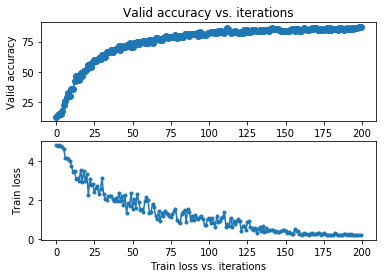

In [55]:
x1 = range(0, len(Accuracy_list)) # 8*10*6
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Valid accuracy vs. iterations')
plt.ylabel('Valid accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. iterations')
plt.ylabel('Train loss')
plt.show()

In [56]:
test_accuracy(loader_val, modelCA)

Checking accuracy on test set ====> 
Got 863 / 1000 correct (86.30)


86.3

In [95]:
import torch.nn.functional as F  
## model CB


model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################

class NetCB(nn.Module):
    def __init__(self):
        super(NetCB, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(96, 96, 3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(96,96,3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv4 = nn.Conv2d(96,192,3,stride=1,padding=1)
        self.conv5 = nn.Conv2d(192,192,3,stride=1,padding=1)
        self.conv6 = nn.Conv2d(192,192,3,stride=1,padding=1)
        # 
        self.conv7 = nn.Conv2d(192,192,3,stride=1,padding=1)
        self.conv8 = nn.Conv2d(192,192,1)
        self.conv9 = nn.Conv2d(192,10,1)
        self.grouppool = nn.AvgPool2d(6,6)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))      
        x = self.grouppool(x)
        x = x.view(x.shape[0],-1)

        return x

In [32]:
Loss_list = []
Accuracy_list = []
learning_rate = 0.01
modelCB = NetCB()
#print(model)
decay = 0.15
for i in range(5):
    learning_rate = learning_rate*decay*(5-i)
    optimizer = optim.SGD(modelCB.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
    train_process(modelCB,optimizer,epochs=5,rounds=i,scale=3.0,Loss_list=Loss_list,Accuracy_list=Accuracy_list)
torch.save(modelCB,'./new_models/modelCB.pkl')

====> rounds: 0
Epoch====>0
Iteration 0, loss = 15.7608
Checking accuracy on validation set
Got 14 / 1000 correct (1.40)
Iteration 100, loss = 8.3289
Checking accuracy on validation set
Got 87 / 1000 correct (8.70)
Iteration 200, loss = 7.9329
Checking accuracy on validation set
Got 175 / 1000 correct (17.50)
Iteration 300, loss = 6.0719
Checking accuracy on validation set
Got 219 / 1000 correct (21.90)
Iteration 400, loss = 5.6770
Checking accuracy on validation set
Got 166 / 1000 correct (16.60)
Iteration 500, loss = 5.7760
Checking accuracy on validation set
Got 310 / 1000 correct (31.00)
Iteration 600, loss = 5.3474
Checking accuracy on validation set
Got 335 / 1000 correct (33.50)
Iteration 700, loss = 5.2378
Checking accuracy on validation set
Got 313 / 1000 correct (31.30)
Epoch====>1
Iteration 0, loss = 4.4413
Checking accuracy on validation set
Got 383 / 1000 correct (38.30)
Iteration 100, loss = 5.0989
Checking accuracy on validation set
Got 364 / 1000 correct (36.40)
Iterati

Iteration 400, loss = 0.4267
Checking accuracy on validation set
Got 849 / 1000 correct (84.90)
Iteration 500, loss = 0.2438
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)
Iteration 600, loss = 0.2648
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)
Iteration 700, loss = 0.1555
Checking accuracy on validation set
Got 857 / 1000 correct (85.70)
Epoch====>1
Iteration 0, loss = 0.2046
Checking accuracy on validation set
Got 857 / 1000 correct (85.70)
Iteration 100, loss = 0.0605
Checking accuracy on validation set
Got 854 / 1000 correct (85.40)
Iteration 200, loss = 0.0956
Checking accuracy on validation set
Got 856 / 1000 correct (85.60)
Iteration 300, loss = 0.1799
Checking accuracy on validation set
Got 855 / 1000 correct (85.50)
Iteration 400, loss = 0.2836
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)
Iteration 500, loss = 0.1671
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)
Iteration 600, loss = 0.1644
C

Epoch====>1
Iteration 0, loss = 0.0059
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)
Iteration 100, loss = 0.0005
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)
Iteration 200, loss = 0.0013
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)
Iteration 300, loss = 0.0002
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)
Iteration 400, loss = 0.0030
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)
Iteration 500, loss = 0.0025
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)
Iteration 600, loss = 0.0016
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)
Iteration 700, loss = 0.0011
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)
Epoch====>2
Iteration 0, loss = 0.0021
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)
Iteration 100, loss = 0.0044
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)
Iteration 200, loss 

/root/Anaconda/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NetCB. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


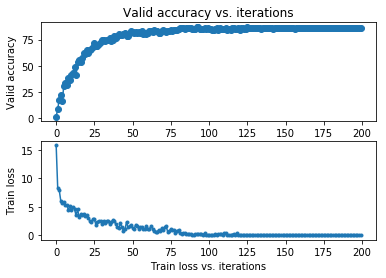

In [33]:
x1 = range(0, len(Accuracy_list)) # 8*10*6
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Valid accuracy vs. iterations')
plt.ylabel('Valid accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. iterations')
plt.ylabel('Train loss')
plt.show()

In [34]:
test_accuracy(loader_test, modelCB)

Checking accuracy on test set
Got 8528 / 10000 correct (85.28)


In [59]:
import torch.nn.functional as F  
## model CC


model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################

class NetCC(nn.Module):
    def __init__(self):
        super(NetCC, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 96, 3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(96,96,3,stride=2,padding=1)
        self.conv4 = nn.Conv2d(96,192,3,stride=1,padding=1)
        self.conv5 = nn.Conv2d(192,192,3,stride=1,padding=1)
        self.conv6 = nn.Conv2d(192,192,3,stride=2,padding=1)
        self.conv7 = nn.Conv2d(192,192,3,stride=1,padding=1)
        self.conv8 = nn.Conv2d(192,192,1)
        self.conv9 = nn.Conv2d(192,10,1)
        self.grouppool = nn.AvgPool2d(6,6)
        #self.fc1 = nn.Linear(40,10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))        
        x = self.grouppool(x)
        x = x.view(x.shape[0],-1)
        #x = F.softmax(x)
        #print(x.shape)
        #x = self.fc1(x)
        return x



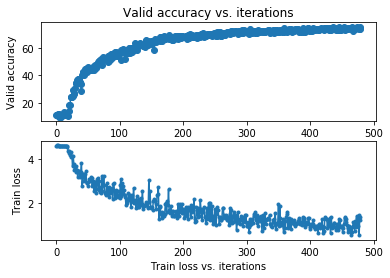

In [41]:
x1 = range(0, len(Accuracy_list)) # 8*10*6
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Valid accuracy vs. iterations')
plt.ylabel('Valid accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. iterations')
plt.ylabel('Train loss')
plt.show()

In [42]:
test_accuracy(loader_test, modelCC)

Checking accuracy on test set
Got 7500 / 10000 correct (75.00)


In [70]:
Loss_list = []
Accuracy_list = []
modelCC = torch.load("./models/modelCC.pkl")
learning_rate = 5e-6
best_acc = 0
best_model = None

#modelA = best_model
decay = 0.7
for i in range(30):
    if i!=0:
        modelCC = best_model
    if i%4==0 and i!=0:
        learning_rate = learning_rate*decay
        
    optimizer = optim.SGD(modelCC.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
    modelB,acc = train_process(modelCC,optimizer,epochs=1,rounds=i,scale=2.0,Loss_list=Loss_list,Accuracy_list=Accuracy_list)
    if acc > best_acc:
        best_model = modelCC
        best_acc = acc
        print("gotcha!")        
    else:
        print("no better")
    print("best_acc: "+str(best_acc))

====> rounds: 0
Epoch====>0
Iteration 0, loss = 1.1985
Checking accuracy on validation set
Got 770 / 1000 correct (77.00)
Checking accuracy on test set ====> 
Got 7710 / 10000 correct (77.10)
Iteration 100, loss = 1.0314
Checking accuracy on validation set
Got 771 / 1000 correct (77.10)
Checking accuracy on test set ====> 
Got 7765 / 10000 correct (77.65)
Iteration 200, loss = 1.2965
Checking accuracy on validation set
Got 774 / 1000 correct (77.40)
Checking accuracy on test set ====> 
Got 7767 / 10000 correct (77.67)
Iteration 300, loss = 1.0628
Checking accuracy on validation set
Got 774 / 1000 correct (77.40)
Checking accuracy on test set ====> 
Got 7778 / 10000 correct (77.78)
Iteration 400, loss = 1.0093
Checking accuracy on validation set
Got 779 / 1000 correct (77.90)
Checking accuracy on test set ====> 
Got 7779 / 10000 correct (77.79)
Iteration 500, loss = 1.1387
Checking accuracy on validation set
Got 778 / 1000 correct (77.80)
Checking accuracy on test set ====> 
Got 7784 / 

Got 7796 / 10000 correct (77.96)
no better
best_acc: 78.09
====> rounds: 6
Epoch====>0
Iteration 0, loss = 1.2992
Checking accuracy on validation set
Got 776 / 1000 correct (77.60)
Checking accuracy on test set ====> 
Got 7793 / 10000 correct (77.93)
Iteration 100, loss = 0.9011
Checking accuracy on validation set
Got 778 / 1000 correct (77.80)
Checking accuracy on test set ====> 
Got 7791 / 10000 correct (77.91)
Iteration 200, loss = 1.1215
Checking accuracy on validation set
Got 771 / 1000 correct (77.10)
Checking accuracy on test set ====> 
Got 7792 / 10000 correct (77.92)
Iteration 300, loss = 1.5457
Checking accuracy on validation set
Got 771 / 1000 correct (77.10)
Checking accuracy on test set ====> 
Got 7796 / 10000 correct (77.96)
Iteration 400, loss = 1.0020
Checking accuracy on validation set
Got 774 / 1000 correct (77.40)
Checking accuracy on test set ====> 
Got 7791 / 10000 correct (77.91)
Iteration 500, loss = 1.1088
Checking accuracy on validation set
Got 776 / 1000 corre

Got 772 / 1000 correct (77.20)
Checking accuracy on test set ====> 
Got 7784 / 10000 correct (77.84)
no better
best_acc: 78.09
====> rounds: 12
Epoch====>0
Iteration 0, loss = 0.8192
Checking accuracy on validation set
Got 772 / 1000 correct (77.20)
Checking accuracy on test set ====> 
Got 7791 / 10000 correct (77.91)
Iteration 100, loss = 1.2286
Checking accuracy on validation set
Got 771 / 1000 correct (77.10)
Checking accuracy on test set ====> 
Got 7793 / 10000 correct (77.93)
Iteration 200, loss = 1.4143
Checking accuracy on validation set
Got 772 / 1000 correct (77.20)
Checking accuracy on test set ====> 
Got 7784 / 10000 correct (77.84)
Iteration 300, loss = 0.9479
Checking accuracy on validation set
Got 772 / 1000 correct (77.20)
Checking accuracy on test set ====> 
Got 7797 / 10000 correct (77.97)
Iteration 400, loss = 1.0677
Checking accuracy on validation set
Got 772 / 1000 correct (77.20)
Checking accuracy on test set ====> 
Got 7792 / 10000 correct (77.92)
Iteration 500, l

Iteration 700, loss = 1.0656
Checking accuracy on validation set
Got 773 / 1000 correct (77.30)
Checking accuracy on test set ====> 
Got 7793 / 10000 correct (77.93)
no better
best_acc: 78.09
====> rounds: 18
Epoch====>0
Iteration 0, loss = 1.3595
Checking accuracy on validation set
Got 770 / 1000 correct (77.00)
Checking accuracy on test set ====> 
Got 7796 / 10000 correct (77.96)
Iteration 100, loss = 0.6760
Checking accuracy on validation set
Got 773 / 1000 correct (77.30)
Checking accuracy on test set ====> 
Got 7791 / 10000 correct (77.91)
Iteration 200, loss = 1.3441
Checking accuracy on validation set
Got 772 / 1000 correct (77.20)
Checking accuracy on test set ====> 
Got 7794 / 10000 correct (77.94)
Iteration 300, loss = 1.0728
Checking accuracy on validation set
Got 774 / 1000 correct (77.40)
Checking accuracy on test set ====> 
Got 7788 / 10000 correct (77.88)
Iteration 400, loss = 0.8528
Checking accuracy on validation set
Got 773 / 1000 correct (77.30)
Checking accuracy on 

Got 7794 / 10000 correct (77.94)
Iteration 700, loss = 1.0902
Checking accuracy on validation set
Got 772 / 1000 correct (77.20)
Checking accuracy on test set ====> 
Got 7793 / 10000 correct (77.93)
no better
best_acc: 78.09
====> rounds: 24
Epoch====>0
Iteration 0, loss = 1.2670
Checking accuracy on validation set
Got 772 / 1000 correct (77.20)
Checking accuracy on test set ====> 
Got 7794 / 10000 correct (77.94)
Iteration 100, loss = 1.2250
Checking accuracy on validation set
Got 773 / 1000 correct (77.30)
Checking accuracy on test set ====> 
Got 7794 / 10000 correct (77.94)
Iteration 200, loss = 0.6045
Checking accuracy on validation set
Got 773 / 1000 correct (77.30)
Checking accuracy on test set ====> 
Got 7789 / 10000 correct (77.89)
Iteration 300, loss = 0.6826
Checking accuracy on validation set
Got 772 / 1000 correct (77.20)
Checking accuracy on test set ====> 
Got 7797 / 10000 correct (77.97)
Iteration 400, loss = 1.6229
Checking accuracy on validation set
Got 774 / 1000 corr

Got 771 / 1000 correct (77.10)
Checking accuracy on test set ====> 
Got 7788 / 10000 correct (77.88)
Iteration 700, loss = 0.9324
Checking accuracy on validation set
Got 772 / 1000 correct (77.20)
Checking accuracy on test set ====> 
Got 7794 / 10000 correct (77.94)
no better
best_acc: 78.09


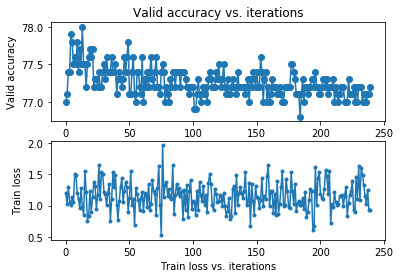

In [71]:
x1 = range(0, len(Accuracy_list)) # 8*10*6
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Valid accuracy vs. iterations')
plt.ylabel('Valid accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. iterations')
plt.ylabel('Train loss')
plt.show()

In [72]:
test_accuracy(loader_test, modelCC)

Checking accuracy on test set ====> 
Got 7793 / 10000 correct (77.93)


77.92999999999999

In [52]:
Loss_list = []
Accuracy_list = []
modelCC = torch.load("./models/modelCC_1.pkl")
learning_rate = 1e-6
decay = 0.5
for i in range(10):
    if i%3==1:
        learning_rate = learning_rate*decay
    optimizer = optim.SGD(modelCC.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
    train_process(modelCC,optimizer,epochs=5,rounds=i,scale=1.0,Loss_list=Loss_list,Accuracy_list=Accuracy_list)
torch.save(modelCC,'./models/modelCC_2.pkl')

====> rounds: 0
Epoch====>0
Iteration 0, loss = 0.5019
Checking accuracy on validation set
Got 754 / 1000 correct (75.40)
Iteration 100, loss = 0.3160
Checking accuracy on validation set
Got 753 / 1000 correct (75.30)
Iteration 200, loss = 0.4162
Checking accuracy on validation set
Got 754 / 1000 correct (75.40)
Iteration 300, loss = 0.4599
Checking accuracy on validation set
Got 754 / 1000 correct (75.40)
Iteration 400, loss = 0.4732
Checking accuracy on validation set
Got 755 / 1000 correct (75.50)
Iteration 500, loss = 0.3998
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)
Iteration 600, loss = 0.4928
Checking accuracy on validation set
Got 755 / 1000 correct (75.50)
Iteration 700, loss = 0.6365
Checking accuracy on validation set
Got 754 / 1000 correct (75.40)
Epoch====>1
Iteration 0, loss = 0.4556
Checking accuracy on validation set
Got 754 / 1000 correct (75.40)
Iteration 100, loss = 0.5039
Checking accuracy on validation set
Got 759 / 1000 correct (75.90)
Iter

Iteration 400, loss = 0.5914
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)
Iteration 500, loss = 0.5937
Checking accuracy on validation set
Got 758 / 1000 correct (75.80)
Iteration 600, loss = 0.4745
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)
Iteration 700, loss = 0.5653
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)
Epoch====>1
Iteration 0, loss = 0.5691
Checking accuracy on validation set
Got 755 / 1000 correct (75.50)
Iteration 100, loss = 0.4951
Checking accuracy on validation set
Got 753 / 1000 correct (75.30)
Iteration 200, loss = 0.6364
Checking accuracy on validation set
Got 753 / 1000 correct (75.30)
Iteration 300, loss = 0.5427
Checking accuracy on validation set
Got 753 / 1000 correct (75.30)
Iteration 400, loss = 0.4618
Checking accuracy on validation set
Got 753 / 1000 correct (75.30)
Iteration 500, loss = 0.4587
Checking accuracy on validation set
Got 754 / 1000 correct (75.40)
Iteration 600, loss = 0.4462
C

Epoch====>1
Iteration 0, loss = 0.4208
Checking accuracy on validation set
Got 755 / 1000 correct (75.50)
Iteration 100, loss = 0.3463
Checking accuracy on validation set
Got 755 / 1000 correct (75.50)
Iteration 200, loss = 0.6254
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)
Iteration 300, loss = 0.4698
Checking accuracy on validation set
Got 758 / 1000 correct (75.80)
Iteration 400, loss = 0.5256
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)
Iteration 500, loss = 0.3603
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)
Iteration 600, loss = 0.5742
Checking accuracy on validation set
Got 754 / 1000 correct (75.40)
Iteration 700, loss = 0.4276
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)
Epoch====>2
Iteration 0, loss = 0.4571
Checking accuracy on validation set
Got 757 / 1000 correct (75.70)
Iteration 100, loss = 0.7132
Checking accuracy on validation set
Got 760 / 1000 correct (76.00)
Iteration 200, loss 

Iteration 400, loss = 0.3857
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)
Iteration 500, loss = 0.5523
Checking accuracy on validation set
Got 755 / 1000 correct (75.50)
Iteration 600, loss = 0.5968
Checking accuracy on validation set
Got 755 / 1000 correct (75.50)
Iteration 700, loss = 0.4210
Checking accuracy on validation set
Got 758 / 1000 correct (75.80)
Epoch====>2
Iteration 0, loss = 0.7161
Checking accuracy on validation set
Got 758 / 1000 correct (75.80)
Iteration 100, loss = 0.7231
Checking accuracy on validation set
Got 757 / 1000 correct (75.70)
Iteration 200, loss = 0.3740
Checking accuracy on validation set
Got 758 / 1000 correct (75.80)
Iteration 300, loss = 0.4075
Checking accuracy on validation set
Got 757 / 1000 correct (75.70)
Iteration 400, loss = 0.5362
Checking accuracy on validation set
Got 757 / 1000 correct (75.70)
Iteration 500, loss = 0.4451
Checking accuracy on validation set
Got 757 / 1000 correct (75.70)
Iteration 600, loss = 0.3578
C

Epoch====>2
Iteration 0, loss = 0.4957
Checking accuracy on validation set
Got 758 / 1000 correct (75.80)
Iteration 100, loss = 0.5370
Checking accuracy on validation set
Got 757 / 1000 correct (75.70)
Iteration 200, loss = 0.3052
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)
Iteration 300, loss = 0.4504
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)
Iteration 400, loss = 0.5242
Checking accuracy on validation set
Got 757 / 1000 correct (75.70)
Iteration 500, loss = 0.4106
Checking accuracy on validation set
Got 758 / 1000 correct (75.80)
Iteration 600, loss = 0.4139
Checking accuracy on validation set
Got 757 / 1000 correct (75.70)
Iteration 700, loss = 0.4837
Checking accuracy on validation set
Got 759 / 1000 correct (75.90)
Epoch====>3
Iteration 0, loss = 0.4149
Checking accuracy on validation set
Got 759 / 1000 correct (75.90)
Iteration 100, loss = 0.4544
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)
Iteration 200, loss 

/root/Anaconda/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NetCC. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


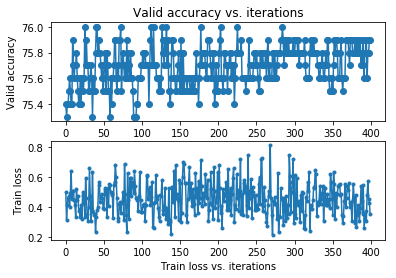

In [53]:
x1 = range(0, len(Accuracy_list)) # 8*10*6
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Valid accuracy vs. iterations')
plt.ylabel('Valid accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. iterations')
plt.ylabel('Train loss')
plt.show()

In [54]:
test_accuracy(loader_test, modelCC)

Checking accuracy on test set
Got 7589 / 10000 correct (75.89)


In [ ]:
x1 = range(0, len(Accuracy_list)) # 8*10*6
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Valid accuracy vs. iterations')
plt.ylabel('Valid accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Train loss vs. iterations')
plt.ylabel('Train loss')
plt.show()